In [1]:
import covasim as cv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import json
from scipy.optimize import minimize


Covasim 3.1.6 (2024-01-28) — © 2020-2024 by IDM


The simulation will take place between start_day and end_day. covasim can not support simulations longer thanb 150 days

In [2]:
start_day = '2020-03-02'
end_day   = '2020-07-01'
date_range = pd.date_range(start=start_day, end=end_day, freq='D')
all_days = cv.date_range(start_day, end_day)
beta_initial=0.015

Extraction of the synthetized data: 

In [3]:
df = pd.read_csv('deaths_and_infections.csv')
# remove a columns from a df: 
df.drop(columns=['Unnamed: 0'], inplace=True)

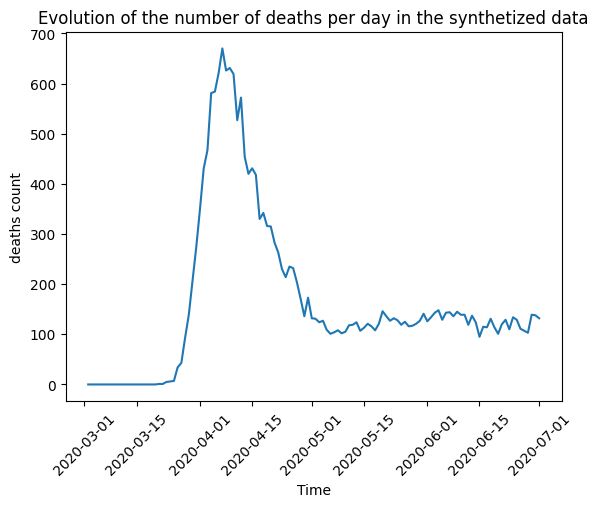

In [4]:
date_range = pd.date_range(start=start_day, end=end_day, freq='D')
plt.plot(date_range, df['new_deaths'], label='new_deaths')
plt.title('Evolution of the number of deaths per day in the synthetized data')
plt.xlabel('Time')
plt.xticks(rotation=45)
plt.ylabel('deaths count')

plt.show()

In [5]:
new_deaths=np.array(df['new_deaths'])
death_cumul=np.array([sum(new_deaths[:i]) for i in range(len(new_deaths))])
dates_of_pandemic=np.arange(len(new_deaths))

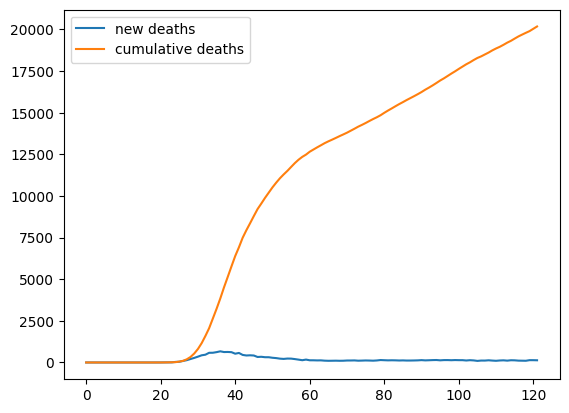

In [6]:
plt.plot(dates_of_pandemic,new_deaths, label='new deaths')
plt.plot(dates_of_pandemic,death_cumul, label='cumulative deaths')
plt.legend()
plt.show()

We now implement our own SIR model

In [7]:
def derive(x, beta, N, gamma, d):
    s=x[0]
    i=x[1]
    r=x[2]
    deads=x[3]
    return np.array([-beta*s*i/N, beta*s*i/N - gamma*i - d * i , gamma*i , d * i ])


In [8]:
def run_sir(x0, beta, gamma,d,  t, dt):
    x=x0
    S=[x[0]]
    I=[x[1]]
    R=[x[2]]
    D=[x[3]] # deads 
    n_iter=int(t/dt)
    N=sum(x0)
    for i in range(n_iter):
        x=x+dt*derive(x, beta, N, gamma, d)
        S.append(x[0])
        I.append(x[1])
        R.append(x[2])
        D.append(x[3])
    s_final=[]
    i_final=[]
    r_final=[]
    d_final=[]
    time=np.linspace(0, t, int(t/dt) )
    for i in range(len(time)-1):
        if abs(time[i]-int(time[i]))<dt: 
            s_final.append(S[i])
            i_final.append(I[i])
            r_final.append(R[i])
            d_final.append(D[i])
    return s_final, i_final, r_final, d_final
    



We run an exeample of SIR with same population size as in the Swedish model: 

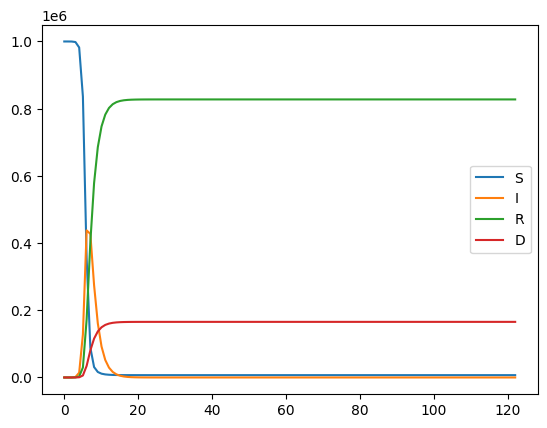

In [9]:
s_0=1000000 -1
i_0=1
r_0=0
d_0=0
beta=0.5
gamma=0.001
d=0.0005
t=len(death_cumul-1)
dt=0.001
beta=3
gamma=0.5
d=0.1
S, I, R, D=run_sir([s_0, i_0, r_0, d_0], beta, gamma,d, t, dt)
time=np.linspace(0, t, t)
plt.plot(time, S,  label='S')
plt.plot(time, I, label='I')
plt.plot(time,R, label='R')
plt.plot(time, D, label='D')
plt.legend()
plt.show()

# Optimization : 

**Curve fit optimization:**

We need to update the SIR to plug it into the curve_fit function

In [10]:
def differenciate(x): 
    dx=[x[i+1]-x[i] for i in range(len(x)-1)]
    return dx


In [11]:


def sir_for_optim(x, beta, gamma, d):
    # x is a list of dates (0 - 122)
    x0=[s_0, i_0, r_0, d_0]
    t=len(x-1)
    S,I,R,D=run_sir(x0, beta, gamma,d,  t, dt)
    zer=np.array([0])
    d_arr=np.array(D)
    return differenciate(np.concatenate((zer,d_arr))) # returns a value per day

In [12]:
# set run_optim = True to run the optim on curve fit
run_optim = True
if run_optim: 
    p, _= curve_fit(sir_for_optim, dates_of_pandemic,new_deaths, p0=( 1,1,1),  bounds=([0,0,0], [5,5,5]))

# results computed previously: 
    

# p=np.array([ 15.84445325, -14.84483028,  30.61694214])
# p = np.array([15.84445325, 85.93020104, 11.82505742])

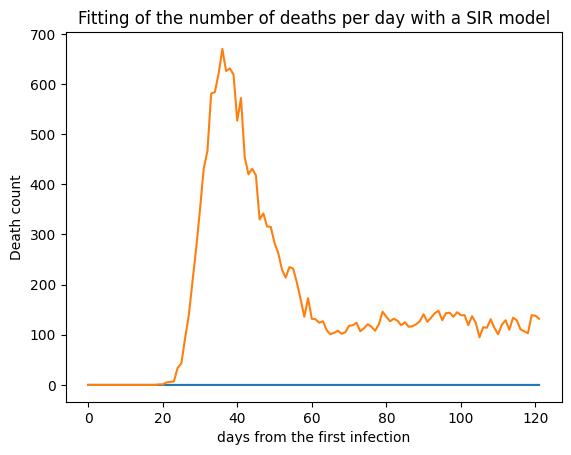

In [13]:
plt.plot(sir_for_optim(dates_of_pandemic, *p))
plt.plot(new_deaths)
plt.xlabel('days from the first infection')
plt.ylabel('Death count')
plt.title('Fitting of the number of deaths per day with a SIR model')
plt.show()

**Optimization with minimize**:

In [14]:
xs=[1,2,3]
ys=[2,4,6] + np.random.normal(0, 0.1, 3)
ys

array([1.97352998, 3.93165732, 6.09593687])

In [15]:
alpha=0.1
def g(x): 
    return alpha*x*x
minimize(g, 1)

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 7.375097765899195e-18
        x: [-8.588e-09]
      nit: 3
      jac: [-2.275e-10]
 hess_inv: [[ 5.000e+00]]
     nfev: 8
     njev: 4

In [16]:
def sir_for_minimize(arg):
    beta=arg [0]
    gamma= arg[1]
    d=arg[2]
    error = np.sum(np.abs(sir_for_optim(dates_of_pandemic, beta, gamma, d) - new_deaths))
    return error
beta =  0.55
gamma =  0.005
d =  0.00025

# set run_minimize = True to run the minimization
run_minimize = False
if run_minimize: 
    a=minimize(sir_for_minimize, [beta, gamma, d], bounds=[(0, 5), (0, 5), (0, 5)])


In [17]:

# precedent computation: 
x=[ 5.477e-01 , 2.555e-02 , 5.523e-04]
beta_minimize=x[0]
gamma_minimize=x[1]
d_minimize=x[2]

Optimization did not seem to work as the loss function is not explicitely differentiable, so we tried a grid search, which enabled us to find clever starting points for the optimization problems: 

Manual search for a clever starting point : 

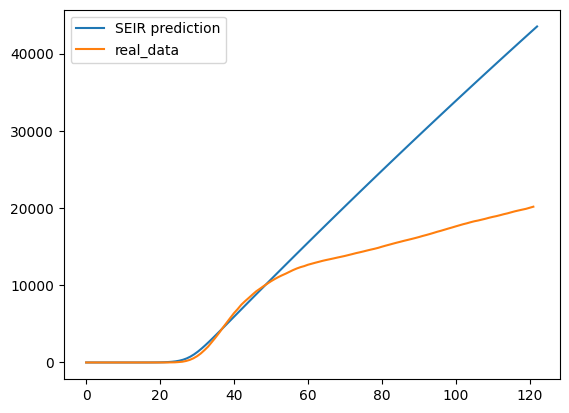

In [18]:
s_0=1000000 -1
i_0=1
r_0=0
d_0=0
beta=0.5
gamma=0.001
d=0.0005
t=len(death_cumul-1)
dt=0.001
%matplotlib inline
S, I, R , D= run_sir([s_0, i_0, r_0, d_0], beta, gamma,d, t, dt)
time=np.linspace(0, t, t)
# plt.plot(time, S,  label='S')
# plt.plot(time, I, label='I')
# plt.plot(time,R, label='R')
plt.plot(time, D, label='SEIR prediction')
plt.plot(death_cumul, label='real_data')
plt.legend()
plt.show()

Grid search : 

In [19]:

betas=np.linspace(0.1, 0.8, 29)
gammas=np.linspace(0.0005, 0.005, 10)
ds=np.linspace(0.0005, 0.005, 10)/2
min=np.sum(np.abs(sir_for_optim(dates_of_pandemic,  0.5, 0.6, 0.3) - new_deaths))
dicoresults=dict()
gammamin=0
betamin=0
dmin=0


run_optim=False
if run_optim:

    for beta in betas: 
        for gamma in gammas: 
            for d in ds:
                error = np.sum(np.abs(sir_for_optim(dates_of_pandemic, beta, gamma, d) - new_deaths))
                if error<min: 
                    min=error
                    gammamin=gamma
                    betamin=beta
                    dmin=d
                    print('new min found')
                    print(min)
                    print('the values are : ')
                    print('beta = ', beta)
                    print('gamma = ', gamma)
                    print('d = ', d)
                dicoresults['beta = '+ str(beta) + ' gamma = '+ str(gamma) + ' d = '+ str(d)]=min
                

    with open('results.json', 'w') as f:
        json.dump(dicoresults, f)
    print('saved')

In [20]:
# load results
with open('results.json', 'r') as f:
    results=json.load(f)
print(results)


{'beta = 0.1 gamma = 0.0005 d = 0.00025': 19926.55663565562, 'beta = 0.1 gamma = 0.0005 d = 0.0005': 19563.673068850843, 'beta = 0.1 gamma = 0.0005 d = 0.00075': 19219.636449057565, 'beta = 0.1 gamma = 0.0005 d = 0.001': 18893.754495424964, 'beta = 0.1 gamma = 0.0005 d = 0.00125': 18652.946907848964, 'beta = 0.1 gamma = 0.0005 d = 0.0015': 18557.77467990922, 'beta = 0.1 gamma = 0.0005 d = 0.00175': 18515.9735751248, 'beta = 0.1 gamma = 0.0005 d = 0.002': 18480.474567608515, 'beta = 0.1 gamma = 0.0005 d = 0.0022500000000000003': 18480.474567608515, 'beta = 0.1 gamma = 0.0005 d = 0.0025': 18480.474567608515, 'beta = 0.1 gamma = 0.001 d = 0.00025': 18480.474567608515, 'beta = 0.1 gamma = 0.001 d = 0.0005': 18480.474567608515, 'beta = 0.1 gamma = 0.001 d = 0.00075': 18480.474567608515, 'beta = 0.1 gamma = 0.001 d = 0.001': 18480.474567608515, 'beta = 0.1 gamma = 0.001 d = 0.00125': 18480.474567608515, 'beta = 0.1 gamma = 0.001 d = 0.0015': 18480.474567608515, 'beta = 0.1 gamma = 0.001 d = 

Viszualisation of the best approximation : 

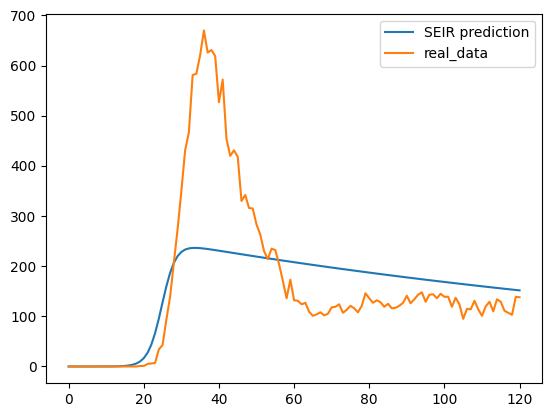

In [21]:
beta =  0.55
gamma =  0.005
d =  0.00025
s_0=1000000 -1
i_0=1
r_0=0
d_0=0

t=len(death_cumul-1)
dt=0.001
%matplotlib inline
S, I, R , D= run_sir([s_0, i_0, r_0, d_0], beta, gamma,d, t, dt)
time=np.linspace(0, t, t)
# plt.plot(time, S,  label='S')
# plt.plot(time, I, label='I')
# plt.plot(time,R, label='R')
plt.plot( differenciate(D), label='SEIR prediction')
plt.plot( differenciate(death_cumul), label='real_data')
plt.legend()
plt.show()

**Visualisation of all the approximations**: 

Text(0.5, 1.0, 'Comparison of different optimal paramerters')

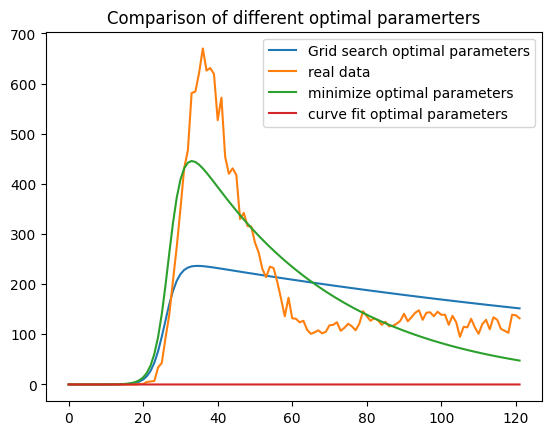

In [22]:
beta_grid =  0.55
gamma_grid =  0.005
d_grid =  0.00025
x=[ 5.477e-01 , 2.555e-02 , 5.523e-04]
beta_minimize=x[0]
gamma_minimize=x[1]
d_minimize=x[2]
p = np.array([15.84445325, 85.93020104, 11.82505742])
plt.plot(sir_for_optim(dates_of_pandemic, beta_grid, gamma_grid, d_grid), label='Grid search optimal parameters')
plt.plot(new_deaths, label='real data')
plt.plot(sir_for_optim(dates_of_pandemic, beta_minimize, gamma_minimize, d_minimize), label='minimize optimal parameters')
plt.plot(sir_for_optim(dates_of_pandemic, *p), label='curve fit optimal parameters')
plt.legend()
plt.title('Comparison of different optimal paramerters')

We faced difficulties to understand the real role of change_beta, the test are here to explain it

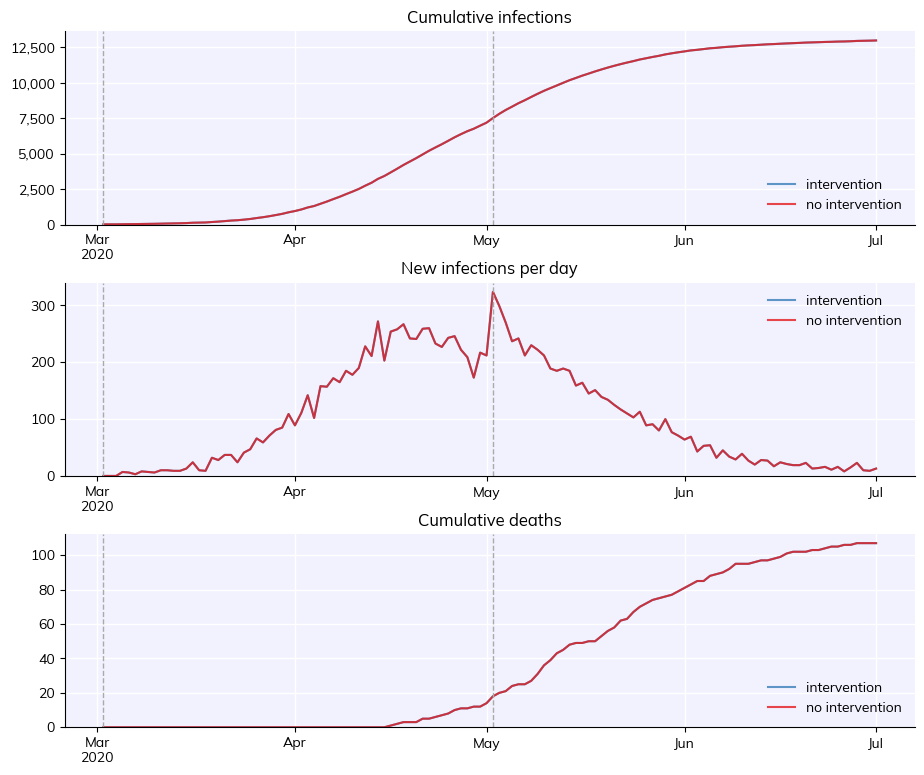

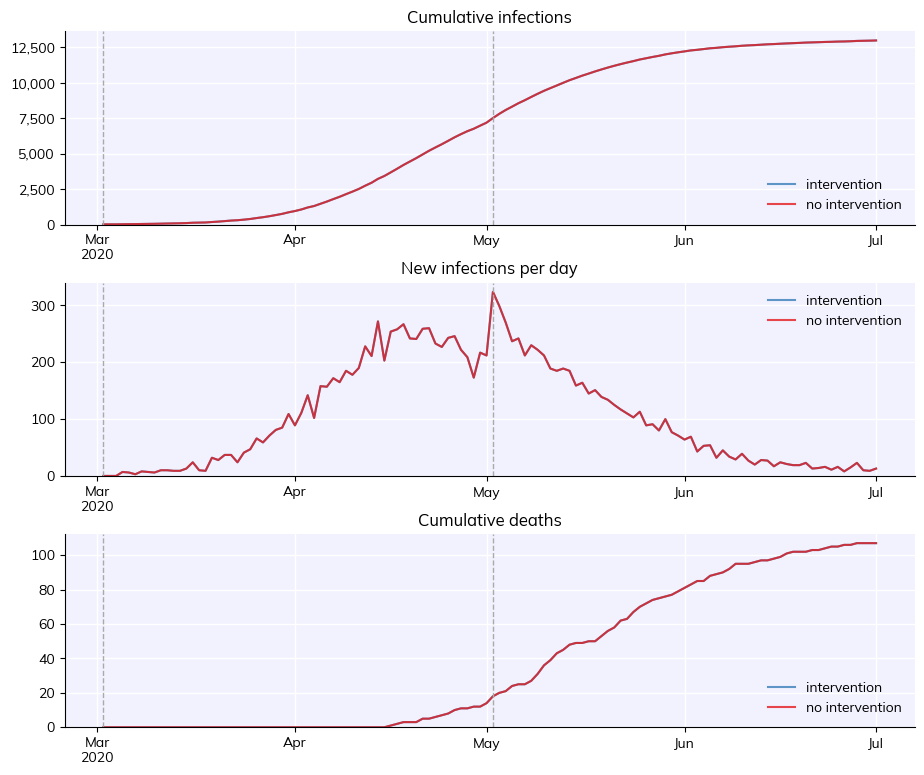

In [ ]:
# THIS CELLE ENABLES TO CHECK WHAT change_beta REALLY DOES






param1=dict(pop_size=10000,  #  10 368 969 is population in Sweden in 2019 according to https://www.worldometers.info/ 
                                             # 1608037 is the population in Stockholm in 2019 according to https://worldpopulationreview.com/

                            start_day = start_day,
                            end_day   = end_day,
                            pop_type = 'hybrid',
                            beta=0.015,  # value to change. There seems to be a problem, as when 
                            # I change the value of beta to 0.15, the curve drastically change when it shoudln't. 
                            # with several tries, it seems that the model begins with a value of beta equal to 1. 
                            location = 'Sweden',
                            pop_infected = 20, #value by default, TOCHANGE
                            
                            )


param2=dict(pop_size=10000,  #  10 368 969 is population in Sweden in 2019 according to https://www.worldometers.info/ 
                                             # 1608037 is the population in Stockholm in 2019 according to https://worldpopulationreview.com/

                            start_day = start_day,
                            end_day   = end_day,
                            pop_type = 'hybrid',
                            beta=1,  # value to change. There seems to be a problem, as when 
                            # I change the value of beta to 0.15, the curve drastically change when it shoudln't. 
                            # with several tries, it seems that the model begins with a value of beta equal to 1. 
                            location = 'Sweden',
                            pop_infected = 20, #value by default, TOCHANGE
                            
                            )




cb1=cv.change_beta(days=['2020-03-02',  '2020-05-02',  ], changes=[1, 2], do_plot=True)
cb2=cv.change_beta(days=['2020-03-02',  '2020-05-02',  ], changes=[0.015, 0.03], do_plot=True)

sim1=cv.Sim(param1, interventions=cb1, label='intervention')
sim2=cv.Sim(param2, interventions=cb2, label='no intervention')
msim=cv.MultiSim([sim1, sim2])
msim.run()
msim.plot()

